Set Working Directory

In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/964505/CT/ct_research/v2'

Packages

In [2]:
import yaml
import numpy as np

import src.experiments.file_io as file_io
import src.experiments.aggregate_average as core
import src.experiments.shared as shared
import src.viz.aggregate_average as viz

from pathlib import Path
from datetime import datetime

from src.utils.reproducibility import set_global_seed
from src.utils.metadata import get_git_commit_hash
from src.utils.config_loading import load_yaml_config

Functions

In [3]:
def compute_score_pair_errors(gt_score_pairs, pred_score_pairs):
    # calculate mean absolute error
    mean_error = np.mean(np.abs(gt_score_pairs - pred_score_pairs))

    # calculate ground truth std
    ground_truth_std = np.std(gt_score_pairs)
    
    return mean_error, ground_truth_std

In [4]:
def evaluate_error_by_missing_count(test_x, test_y, test_predictions, dims=14):
    _, cur_score = core.split_encoding_and_scores(test_x, dims=dims)
    future_score_gt = test_y

    mean_errors_list = []
    ground_truth_std_list = []
    ground_truth_dict = {}
    missing_counts = list(range(0, dims))

    for n in missing_counts:
        filter_mask = core.filter_sessions_by_missing_count(cur_score, n)
        filtered_gt = future_score_gt[filter_mask]
        filtered_pred = test_predictions[filter_mask]

        ground_truth_dict[str(n)] = filtered_gt

        if filtered_gt.size == 0:
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            continue

        mean_error, std_dev = compute_score_pair_errors(filtered_gt, filtered_pred)
        mean_errors_list.append(mean_error)
        ground_truth_std_list.append(std_dev)

    return missing_counts, mean_errors_list, ground_truth_std_list, ground_truth_dict

Script

In [5]:
config_path = "config/experiments/20250624_aggavg_1.yaml"

In [6]:
# load configuration
config = load_yaml_config(config_path)
run_type = config["settings"]["type"] # repeat vs non-repeat
device = config["settings"]["device"] # cpu or cuda
seed = config["settings"]["seed"]

data_source = config["data"]["data_source"] # npz file with multiple arrays
model_source = config["data"]["model_source"] # path to the model
output_destination = config["data"]["destination_base"]

In [7]:
## general setup
figure_names = ["accuracy_assessment.png", "aggregate_average.png"]


## set global seed
set_global_seed(seed)

## get git commit hash
git_commit_hash = get_git_commit_hash()

In [8]:
## read data
test_x, test_y = file_io.load_test_data(
    file_path=data_source,
    file_names=["test_x", "test_y"]
)

test_predictions = file_io.load_saved_test_predictions(
    file_path=data_source
)

In [9]:
test_x.shape, test_y.shape, test_predictions.shape

((100000, 42), (100000, 14), (100000, 14))

In [10]:
## filter by session type
repeat_mask = core.assign_repeat(test_x)

In [11]:
repeat_mask.sum()

np.int64(97428)

In [12]:
# if run type is repeat, filter for only repeat sessions
# if run type is non-repeat, filter for only non-repeat sessions
if run_type == "repeat":
    test_x = test_x[repeat_mask]
    test_y = test_y[repeat_mask]
    test_predictions = test_predictions[repeat_mask]
elif run_type == "non-repeat":
    test_x = test_x[~repeat_mask]
    test_y = test_y[~repeat_mask]
    test_predictions = test_predictions[~repeat_mask]

In [13]:
test_x.shape, test_y.shape, test_predictions.shape

((97428, 42), (97428, 14), (97428, 14))

(1) find ground truth std and prediction MAE

In [14]:
_, cur_score = core.split_encoding_and_scores(test_x, dims=14)
future_score_gt = test_y

mean_errors_list = []
ground_truth_std_list = []
ground_truth_dict = {}
missing_counts = list(range(0, 14))

In [15]:
n = 1
filter_mask = core.filter_sessions_by_missing_count(cur_score, n)

In [16]:
filter_mask.sum()

np.int64(22550)

In [17]:
filtered_gt = future_score_gt[filter_mask]
filtered_pred = test_predictions[filter_mask]

In [18]:
filtered_gt.shape, filtered_pred.shape

((22550, 14), (22550, 14))

In [19]:
ground_truth_dict[str(n)] = filtered_gt

if filtered_gt.size == 0:
    mean_errors_list.append(np.nan)
    ground_truth_std_list.append(np.nan)

In [20]:
mean_error, std_dev = compute_score_pair_errors(filtered_gt, filtered_pred)
mean_errors_list.append(mean_error)
ground_truth_std_list.append(std_dev)

In [21]:
mean_error, std_dev

(np.float32(0.008279069), np.float32(0.17967004))

In [22]:
mean_errors_list = []
ground_truth_std_list = []
ground_truth_dict = {}
missing_counts = list(range(0, 14))

In [23]:
for n in missing_counts:
    filter_mask = core.filter_sessions_by_missing_count(cur_score, n)
    filtered_gt = future_score_gt[filter_mask]
    filtered_pred = test_predictions[filter_mask]

    ground_truth_dict[str(n)] = filtered_gt

    if filtered_gt.size == 0:
        mean_errors_list.append(np.nan)
        ground_truth_std_list.append(np.nan)
        continue

    mean_error, std_dev = compute_score_pair_errors(filtered_gt, filtered_pred)
    mean_errors_list.append(mean_error)
    ground_truth_std_list.append(std_dev)

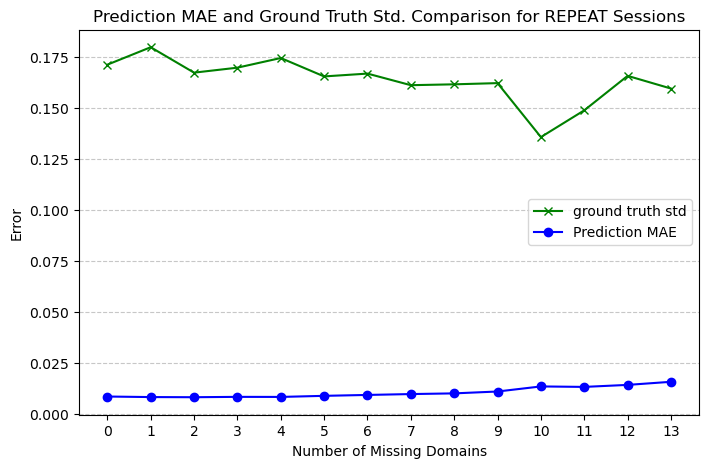

In [24]:
# plot error by missing count and save figure
viz.plot_error_by_missing_count(
    missing_counts=missing_counts,
    std=ground_truth_std_list,
    error=mean_errors_list,
    run_type=run_type
)

(2) predict scores based on strategy

In [25]:
# load model
model = shared.load_model(
    model_path=model_source,
    device=device
)

In [26]:
# ground truth original scores
_, scores_gt = core.split_encoding_and_scores(test_x, dims=14)

In [27]:
# ground truth future scores
future_scores_gt = test_predictions

In [28]:
scores_gt.shape, future_score_gt.shape

((97428, 28), (97428, 14))

In [29]:
# best
prediction_list = []
rows, cols = test_y.shape
_, scores = core.split_encoding_and_scores(test_x, dims=14)
for domain in range(14):
    print("============= domain %d" % (domain + 1))
    encoding = core.create_single_encoding(rows, cols, domain)
    print("encoding: ", encoding)
    tmp_single = core.add_encoding(scores, encoding)
    print("data put in model", tmp_single)
    single_prediction = shared.inference(model, tmp_single)
    print("prediction: ", single_prediction)
    prediction_list.append(single_prediction[:, domain])

prediction_matrix = np.column_stack(prediction_list)
difference = prediction_matrix - scores[:, ::2]

# find max indices
max_values, max_indices = shared.max_prediction_from_difference(difference, prediction_matrix, scores)
# reconstruct matrices
future_scores_best, best_encoding = core.reconstruct_max_matrices(max_values, max_indices, prediction_matrix.shape)


============= domain 1
encoding:  [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
data put in model tensor([[1.0000, 0.0000, 0.0000,  ..., 0.4240, 0.6670, 0.3330],
        [1.0000, 0.0000, 0.0000,  ..., 0.1030, 0.9600, 0.0400],
        [1.0000, 0.0000, 0.0000,  ..., 0.6220, 0.6470, 0.3530],
        ...,
        [1.0000, 0.0000, 0.0000,  ..., 0.1210, 0.6670, 0.3330],
        [1.0000, 0.0000, 0.0000,  ..., 0.3640, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.2160, 0.9400, 0.0600]])
prediction:  [[ 4.2815512e-01 -4.0813610e-03 -4.3222848e-03 ... -1.2307614e-03
   3.2396480e-03  5.8489479e-04]
 [ 4.2995912e-01  7.9433247e-03 -1.9125286e-03 ... -2.8290898e-03
   6.9698557e-04  7.1702097e-03]
 [ 1.4297935e-01  9.6511543e-03  7.3432634e-03 ... -9.1973692e-04
   2.4508974e-03 -2.4811793e-03]
 ...
 [ 7.1868932e-01  1.9110143e-02  2.5743349e-03 ... -7.0737600e-03
   4.3933443e-03  6.7559816e-04]
 [ 5.8438855e-01

In [30]:
future_scores_best.shape, best_encoding.shape

((97428, 14), (97428, 14))

In [31]:
# random
future_scores_random = core.find_random_predictions(
    model=model,
    data=test_x,
    run_type=run_type
)

In [32]:
future_scores_random.shape

(97428, 14)

In [35]:
average_gt_list = []
average_best_list = []
average_random_list = []

std_gt_list = []
std_best_list = []
std_random_list = []

In [36]:
for n in missing_counts:
    missing_mask = core.filter_sessions_by_missing_count(scores_gt, n)
    
    scores_gt_tmp = scores_gt[missing_mask][:, ::2]

    future_scores_gt_tmp = future_scores_gt[missing_mask]
    future_scores_best_tmp = future_scores_best[missing_mask]
    future_scores_random_tmp = future_scores_random[missing_mask]

    difference_gt = future_scores_gt_tmp - scores_gt_tmp
    difference_best = future_scores_best_tmp - scores_gt_tmp
    difference_random = future_scores_random_tmp - scores_gt_tmp

    average_gt = np.mean(np.abs(difference_gt))
    average_best = np.mean(np.abs(difference_best))
    average_random = np.mean(np.abs(difference_random))

    std_gt = np.std(difference_gt)
    std_best = np.std(difference_best)
    std_random = np.std(difference_random)

    average_gt_list.append(average_gt)
    average_best_list.append(average_best)
    average_random_list.append(average_random)

    std_gt_list.append(std_gt)
    std_best_list.append(std_best)
    std_random_list.append(std_random)

In [37]:
import matplotlib.pyplot as plt

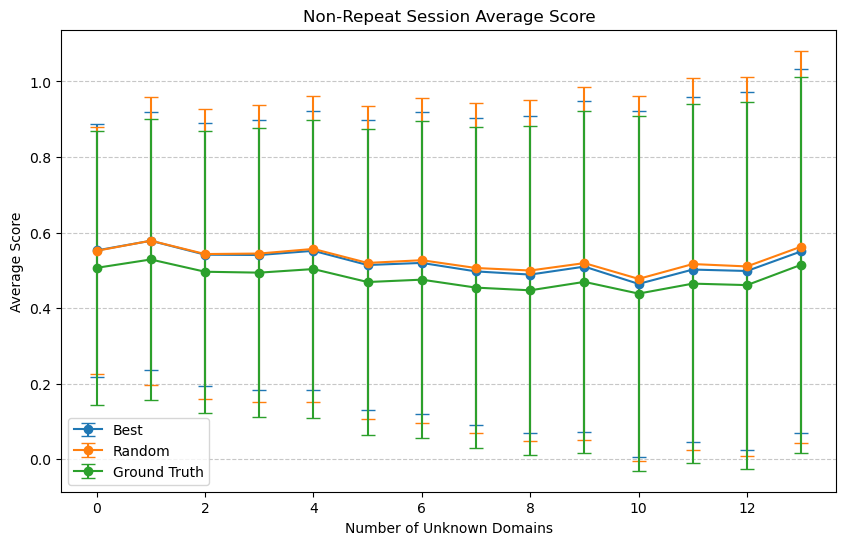

In [38]:
# Define x-axis values (number of unknown domains)
# Plot with error bars
plt.figure(figsize=(10, 6))

plt.errorbar(missing_counts, average_best_list, yerr=std_best_list, label="Best", fmt='-o', capsize=5)
plt.errorbar(missing_counts, average_random_list, yerr=std_random_list, label="Random", fmt='-o', capsize=5)
plt.errorbar(missing_counts, average_gt_list, yerr=std_gt_list, label="Ground Truth", fmt='-o', capsize=5)

# Labels and Title
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Score")
plt.title("Non-Repeat Session Average Score")

# Legend and Grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [ ]:
    # get score pairs
    gt_score_pairs = core.extract_score_pairs(gt_score_pairs)
    pred_score_pairs = core.extract_score_pairs(pred_score_pairs)

    # find valid score pairs
    valid_mask = core.find_missing_mask(gt_score_pairs[:, :, 0], gt_score_pairs[:, :, 1])

    # filter valid score pairs
    gt_score_pairs = gt_score_pairs[valid_mask]
    pred_score_pairs = pred_score_pairs[valid_mask]

    

NameError: name 'gt_score_pairs' is not defined